/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-L_den-8k_label-dentate_*subfields*.label.gii failed (no matches)
/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-R_den-8k_label-dentate_*subfields*.label.gii failed (no matches)


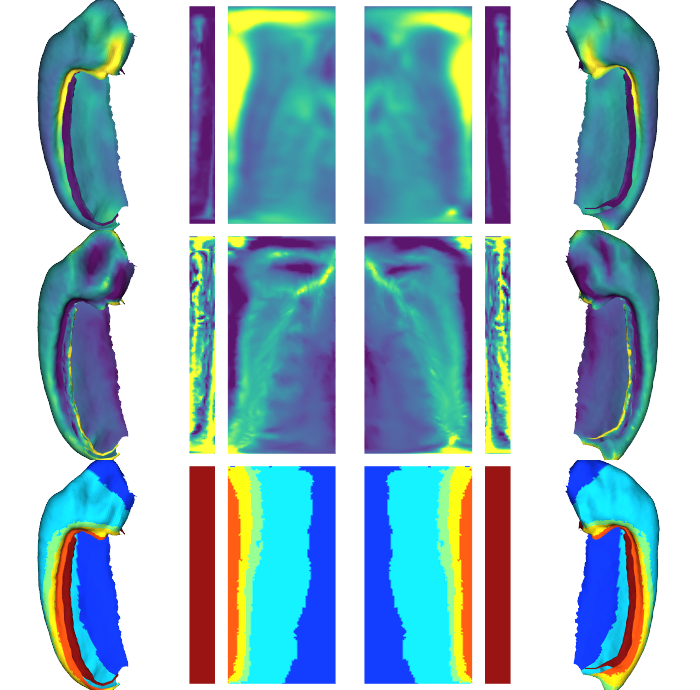

In [24]:
import hippomaps as hm
hm.plotting.surfplot_sub_foldunfold("/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/", "PNC010", "01", ["thickness", "curvature", "subfields"], den="8k", embed_nb=True)

/export03/data/tmp/ipykernel_3259448/300182043.py:53: UserWarning: Missing metric (skipping): /host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-L_den-8k_label-dentate_*subfields*.label.gii
  warnings.warn(f"Missing metric (skipping): {pat}")
/export03/data/tmp/ipykernel_3259448/300182043.py:53: UserWarning: Missing metric (skipping): /host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-R_den-8k_label-dentate_*subfields*.label.gii
  warnings.warn(f"Missing metric (skipping): {pat}")
/export03/data/tmp/ipykernel_3259448/300182043.py:188: UserWarning: Dentate subfields missing for hemi-L; filling with max(hipp)+1.
  warnings.warn(f"Dentate subfields missing for hemi-{hemi}; filling with max(hipp)+1.")
/export03/data/tmp/ipykernel_3259448/300182043.py:188: UserWarning: Dentate subfields missing for hemi-R; filling with max(hipp)+1.
  warnings.warn(f"Dentate subfields missi

hemi=L label=dentate: chosen XY transform = my+swap
hemi=L label=hipp: chosen XY transform = my+swap
hemi=R label=dentate: chosen XY transform = swap
hemi=R label=hipp: chosen XY transform = swap


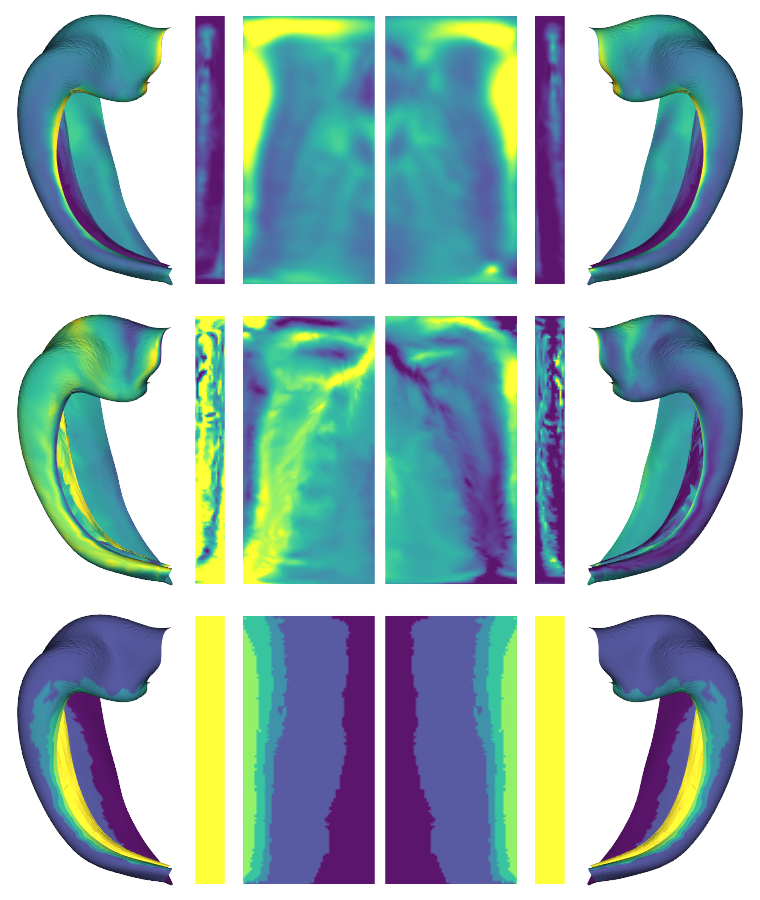

In [52]:
import numpy as np
import nibabel as nib
import glob
import warnings
from pathlib import Path
from scipy.spatial import cKDTree
from nibabel.nifti1 import intent_codes

import hippomaps.plotting as hm  # your plotting.py module

# ----------------------------
# Inputs
# ----------------------------
hippunfold_dir = Path("/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/")
sub = "PNC010"
ses = "01"
den = "8k"
features = ["thickness", "curvature", "subfields"]
hemis = ["L", "R"]
labels = ["hipp", "dentate"]

subjroot = hippunfold_dir / f"sub-{sub}" / f"ses-{ses}"
metric_dir = subjroot / "metric"
surf_dir = subjroot / "surf"

resourcesdir = Path(hm.resourcesdir)

# ----------------------------
# GIFTI point extractor
# ----------------------------
def gifti_points(gii: nib.gifti.GiftiImage) -> np.ndarray:
    code = intent_codes["NIFTI_INTENT_POINTSET"]
    for da in gii.darrays:
        if da.intent == code:
            return np.asarray(da.data, dtype=np.float32)
    try:
        arrs = gii.get_arrays_from_intent("NIFTI_INTENT_POINTSET")
        if arrs:
            return np.asarray(arrs[0].data, dtype=np.float32)
    except Exception:
        pass
    raise ValueError("No POINTSET array found in this GIFTI surface.")


# ----------------------------
# Load metric vectors (missing allowed)
# ----------------------------
def load_metric_vec(hemi: str, label: str, feature: str) -> np.ndarray | None:
    gii_type = "label" if feature == "subfields" else "shape"
    pat = metric_dir / f"sub-{sub}_ses-{ses}_hemi-{hemi}_den-{den}_label-{label}_*{feature}*.{gii_type}.gii"
    matches = glob.glob(str(pat))
    if not matches:
        warnings.warn(f"Missing metric (skipping): {pat}")
        return None
    return np.asarray(nib.load(matches[0]).darrays[0].data, dtype=np.float32)


# ----------------------------
# Load unfolded coordinates
# ----------------------------
def load_unfold_points_subject(hemi: str, label: str) -> np.ndarray:
    fn = surf_dir / f"sub-{sub}_ses-{ses}_hemi-{hemi}_space-unfold_den-{den}_label-{label}_midthickness.surf.gii"
    return gifti_points(nib.load(str(fn)))


def load_unfold_points_canon_shared(label: str) -> np.ndarray:
    fn = resourcesdir / "canonical_surfs" / f"tpl-avg_space-unfold_den-{den}_label-{label}_midthickness.surf.gii"
    return gifti_points(nib.load(str(fn)))


# ----------------------------
# NaN fill in canonical space
# ----------------------------
def fill_nans_nearest_in_xy(v: np.ndarray, xy: np.ndarray) -> np.ndarray:
    out = v.copy()
    bad = ~np.isfinite(out)
    if not np.any(bad):
        return out
    good = np.isfinite(out)
    if np.sum(good) == 0:
        return out
    tree = cKDTree(xy[good])
    _, nn = tree.query(xy[bad], k=1)
    out[bad] = out[good][nn]
    return out


# ----------------------------
# Best-fit transform between subject XY and canonical XY
# ----------------------------
def _xy_variants(xy: np.ndarray):
    x = xy[:, 0]
    y = xy[:, 1]
    # returns list of (name, transformed_xy)
    return [
        ("id", np.column_stack([x, y])),
        ("swap", np.column_stack([y, x])),
        ("mx", np.column_stack([-x, y])),
        ("my", np.column_stack([x, -y])),
        ("mx+swap", np.column_stack([y, -x])),
        ("my+swap", np.column_stack([-y, x])),
    ]


def choose_best_canon_xy_for_subject(subj_xy: np.ndarray, canon_xy: np.ndarray) -> tuple[str, np.ndarray]:
    """
    Pick the transform of canon_xy that best matches subj_xy under NN distance.
    Uses median NN distance as a robust score.
    """
    tree = cKDTree(subj_xy)
    best_name = None
    best_xy = None
    best_score = np.inf

    for name, cxy in _xy_variants(canon_xy):
        d, _ = tree.query(cxy, k=1)
        score = float(np.median(d))
        if score < best_score:
            best_score = score
            best_name = name
            best_xy = cxy

    return best_name, best_xy


def remap_to_canon(subject_vec: np.ndarray, subj_pts: np.ndarray, canon_pts: np.ndarray) -> np.ndarray:
    subj_xy = subj_pts[:, :2].astype(np.float32)
    canon_xy = canon_pts[:, :2].astype(np.float32)

    name, canon_xy_best = choose_best_canon_xy_for_subject(subj_xy, canon_xy)

    # remap: for each canonical vertex, take NN subject value
    tree = cKDTree(subj_xy)
    _, nn = tree.query(canon_xy_best, k=1)
    return subject_vec[nn], name


# ----------------------------
# Build cdata in canonical order: (V, H, F)
# ----------------------------
canon_pts = {label: load_unfold_points_canon_shared(label) for label in labels}
n_canon = {label: canon_pts[label].shape[0] for label in labels}

V = n_canon["hipp"] + n_canon["dentate"]
H = len(hemis)
F = len(features)
cdata = np.full((V, H, F), np.nan, dtype=np.float32)

hipp_sl = slice(0, n_canon["hipp"])
dent_sl = slice(n_canon["hipp"], n_canon["hipp"] + n_canon["dentate"])

# store which transform got chosen (useful debug)
chosen = {}

for h, hemi in enumerate(hemis):
    offset = 0
    for label in labels:
        subj_pts = load_unfold_points_subject(hemi, label)

        for f, feature in enumerate(features):
            v = load_metric_vec(hemi, label, feature)
            if v is None:
                continue

            v_canon, xform = remap_to_canon(v, subj_pts, canon_pts[label])
            cdata[offset:offset + n_canon[label], h, f] = v_canon
            chosen[(hemi, label, feature)] = xform

        offset += n_canon[label]

# Optional: print what transforms were used (helps confirm L is mirrored/swapped)
for key, xf in sorted(chosen.items()):
    hemi, label, feature = key
    if feature == features[0]:  # print once per label/hemi (or delete this if you want all)
        print(f"hemi={hemi} label={label}: chosen XY transform = {xf}")

# ----------------------------
# Fill missing subfields (dentate) + inpaint remaining NaNs
# ----------------------------
if "subfields" in features:
    sf_idx = features.index("subfields")
    for h, hemi in enumerate(hemis):
        hipp_max = np.nanmax(cdata[hipp_sl, h, sf_idx])
        if np.isfinite(hipp_max) and np.all(~np.isfinite(cdata[dent_sl, h, sf_idx])):
            warnings.warn(f"Dentate subfields missing for hemi-{hemi}; filling with max(hipp)+1.")
            cdata[dent_sl, h, sf_idx] = hipp_max + 1

# inpaint remaining NaNs using canonical XY within each label block
for f, feature in enumerate(features):
    for h, hemi in enumerate(hemis):
        cdata[hipp_sl, h, f] = fill_nans_nearest_in_xy(cdata[hipp_sl, h, f], canon_pts["hipp"][:, :2])
        cdata[dent_sl, h, f] = fill_nans_nearest_in_xy(cdata[dent_sl, h, f], canon_pts["dentate"][:, :2])

# ----------------------------
# Plot canonical folded/unfolded
# ----------------------------
fig = hm.surfplot_canonical_foldunfold(
    cdata,
    hemis=hemis,
    labels=labels,
    den=den,
    tighten_cwindow=True,
    zoom=1.7,
    color_bar=True,
    embed_nb=True
)

fig


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 10240.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([4.5       , 4.51000023, 4.51999998, 4.53000021, 4.53999996,
        4.55000019, 4.5599

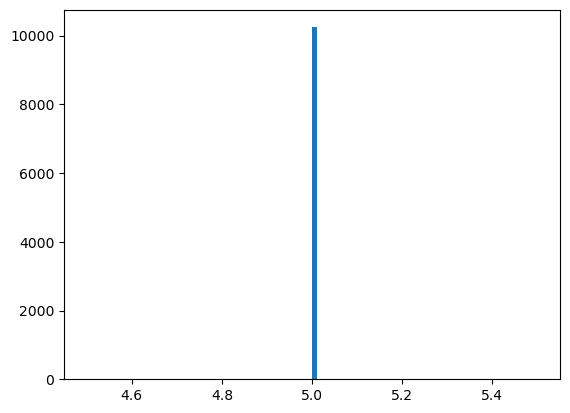

In [48]:
import matplotlib.pyplot as plt
plt.hist(cdata[:,0,2], 100)